<a href="https://colab.research.google.com/github/guptavasu1213/glaucoma-identification/blob/master/OD_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# import the necessary packages
from imutils import contours
from skimage import measure
import numpy as np
import argparse
import imutils
import cv2
from google.colab.patches import cv2_imshow
import PIL

In [3]:
def point_check(pt):
  newpt = [0,0]
  newpt[0] = 0 if pt[0] < 0 else pt[0]
  newpt[1] = 0 if pt[1] < 0 else pt[1]
  return tuple(newpt)

In [4]:
import numpy as np

x = np.eye(4).astype(int)
measure.label(x, connectivity=1, background=0)

array([[1, 0, 0, 0],
       [0, 2, 0, 0],
       [0, 0, 3, 0],
       [0, 0, 0, 4]])

In [7]:
output_dim = 512
def cropONH(imageName):
	data_set = {"n":"Training", "V":"Validation", "T":"Testing"}
	
	folderName= data_set[imageName[0]]

	img_path = "drive/Shared drives/Capstone Summer 2020/Data/Original/"+ folderName +"/Images/"+ imageName +".jpg"

	image = PIL.Image.open(img_path)
	im_w, im_h = image.size
	var = round(0.15 * im_w)
	starting_threshold = 250
	while True:
		# load the image, convert it to grayscale, and blur it
		image = cv2.imread(img_path)

		# image=cv2.resize(image,(800,615))
		gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		blur = cv2.bilateralFilter(gray,9,75,75)
		median=cv2.medianBlur(gray,5)

		# cv2_imshow(median)

		# threshold the image to reveal light regions in the
		# blurred image
		thresh = cv2.threshold(median, starting_threshold, 255, cv2.THRESH_BINARY)[1]
		# cv2_imshow(thresh)

		# perform a series of erosions and dilations to remove
		# any small blobs of noise from the thresholded image
		thresh = cv2.erode(thresh, None, iterations=2)
		thresh = cv2.dilate(thresh, None, iterations=4)

		# perform a connected component analysis on the thresholded
		# image, then initialize a mask to store only the "large"
		# components
		labels = measure.label(thresh, neighbors=8, background=0)
		mask = np.zeros(thresh.shape, dtype="uint8")
		# return
		print(labels)
		print(np.unique(labels))
		
		largest_blob = 0
		# loop over the unique components
		for label in np.unique(labels):
			# if this is the background label, ignore it
			if label == 0:
				continue
			print("Creating mask")
			# otherwise, construct the label mask and count the
			# number of pixels 
			labelMask = np.zeros(thresh.shape, dtype="uint8")
			labelMask[labels == label] = 255
			numPixels = cv2.countNonZero(labelMask)
			# cv2_imshow(labelMask)
			# print('==============')
			# if the number of pixels in the component is sufficiently
			# large, then add it to our mask of "large blobs"
			if numPixels > largest_blob:
				largest_blob = numPixels 
				mask = labelMask
			# if numPixels > 100:
			# 	mask = cv2.add(mask, labelMask)

		# cv2_imshow(mask)
		# return
		# find the contours in the mask, then sort them from left to
		# right
		cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
			cv2.CHAIN_APPROX_SIMPLE)
		# cv2.drawContours(image, cnts, -1, (0,255,0), 3)
		# return
		cnts = imutils.grab_contours(cnts)
	
		#If there is nothing found for the image
		if cnts == []:
			starting_threshold -= 10
			print("Decreasing threshold by 10. Now:", starting_threshold)
			continue
		# print(cnts)

		# cv2_imshow(mask)
		cnts = contours.sort_contours(cnts)[0]
		# loop over the contours
		for (i, c) in enumerate(cnts):
			# ellipse = cv2.fitEllipse(c)
			(x, y, w, h) = cv2.boundingRect(c)

			center = (round(x+(w/2)), round(y+(h/2)))
			
			cv2.putText(image, "O", center,
						cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
   
			box_radius = output_dim//2

			tl_pt = [center[0]-box_radius, center[1]-box_radius]
			br_pt = [center[0]+box_radius, center[1]+box_radius]

			#Check if TL point is out of bounds
			if tl_pt[0] < 0:
				neg = tl_pt[0] * -1
				tl_pt[0] = 0
				br_pt[0] += neg

			if tl_pt[1] < 0:
				neg = tl_pt[1] * -1
				tl_pt[1] = 0
				br_pt[1] += neg

			#Check if BR point is out of bounds
			if br_pt[0] > im_w:
				pos = im_w-br_pt[0]
				br_pt[0] = im_w
				tl_pt[0] -= pos
			if br_pt[1] > im_h:
				pos = im_h-br_pt[1]
				br_pt[1] = im_h
				tl_pt[1] -= pos

			# tl_pt = point_check((x-var,y-var))
			# br_pt = point_check((x+w+var,y+h+var))
			cv2.rectangle(image,tuple(tl_pt) , tuple(br_pt), (255,0,0), 3)
			
			break

		print("Wid: ", br_pt[0]-tl_pt[0], "\tHei:", br_pt[1]-tl_pt[1])			
		image=cv2.resize(image,(512,512))
		cv2_imshow(image)
		break
	return tl_pt[0], tl_pt[1], br_pt[0], br_pt[1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=2


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0]
Decreasing threshold by 10. Now: 240
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 1]
Creating mask
Wid:  512 	Hei: 512


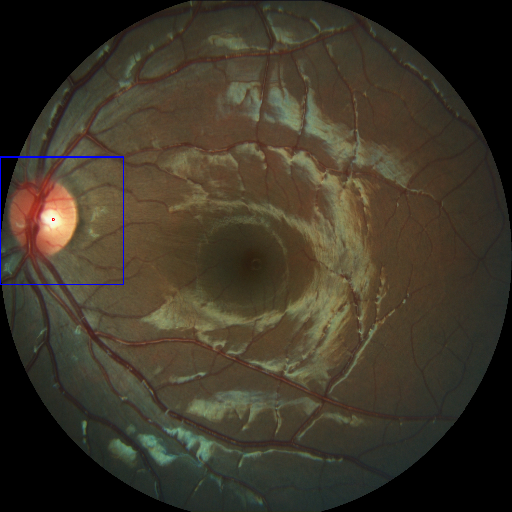

(0, 630, 512, 1142)

In [8]:
# for i in range(356, 401):
#     img_name = "T" + str(i).zfill(4)
#     print(img_name)
#     cropONH(img_name)

cropONH("n0137")
#n231 361 309
#T0118 crash + more in phone



#n0309 and T0397, n0322

#T0128 and n0348 are fixed with greater box size

#V351 is ok; 213 and 193 are bad